# Logistic Regression

The second model can be one of our choosing. Here I will implement a Logistic Regression (which typically performs better than any of the NB models)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re

# https://scikit-learn.org/stable/modules/naive_bayes.html
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import balanced_accuracy_score, f1_score
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [4]:
# read in clean data, inspect
data = pd.read_csv('./data/clean_subreddits.csv')


data.head(2)

,num_comments,score,selftext,subreddit,title,clean_selftext,clean_title,wordcount_clean_selftext,wordcount_clean_title
0,1,0,**Maybe it's *staged* right**?! We all know th...,C_S_T,Koch Brother and Trump biographer kicked out o...,maybe staged right know koch bros der juden co...,koch brother trump biographer kicked trump gol...,160,8
1,21,31,[Part 1: It Starts With Your Thinking](https:/...,C_S_T,How Not To Get Sick - Part 3: Discarding Your ...,part 1 start thinking http www reddit com r c_...,get sick part 3 discarding victim mentality,950,7


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   num_comments              1000 non-null   int64 
 1   score                     1000 non-null   int64 
 2   selftext                  1000 non-null   object
 3   subreddit                 1000 non-null   object
 4   title                     1000 non-null   object
 5   clean_selftext            1000 non-null   object
 6   clean_title               997 non-null    object
 7   wordcount_clean_selftext  1000 non-null   int64 
 8   wordcount_clean_title     1000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [3]:
# subreddit must be numeric val
data['subreddit'], vals = pd.factorize(data['subreddit'])

data['subreddit'].value_counts(normalize=True)

0    0.5
1    0.5
Name: subreddit, dtype: float64

In [8]:
# set X & y
X = data['clean_selftext']
y = data['subreddit']

# TTS
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#check shape
print(X_train.shape, y_train.shape)

(750,) (750,)


In [34]:
# instantiate models for use, create list
lr = LogisticRegression(max_iter=2_000, random_state=42) #set max iter to take care of convergence warning
ada = AdaBoostClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)
#hbc = HistGradientBoostingClassifier()
rfc = RandomForestClassifier(random_state=42)

classifiers = [lr, ada, gbc, rfc]

In [35]:
#function to loop through
def cv_estimator(vectorizer, classifier):
    pipe = make_pipeline(vectorizer, classifier)
    pipe.fit(X_train, y_train)
    train_score = pipe.score(X_train, y_train)
    test_score = pipe.score(X_test, y_test)
    
    return vectorizer, classifier, train_score, test_score

In [37]:
# CVect with and without stop words
for i in classifiers:
    print(cv_estimator(CountVectorizer(stop_words='english'), i))
    print(cv_estimator(CountVectorizer(stop_words=None), i))

(CountVectorizer(stop_words='english'), LogisticRegression(max_iter=2000, random_state=42), 0.9946666666666667, 0.632)
(CountVectorizer(), LogisticRegression(max_iter=2000, random_state=42), 0.9946666666666667, 0.652)
(CountVectorizer(stop_words='english'), AdaBoostClassifier(random_state=42), 0.8653333333333333, 0.612)
(CountVectorizer(), AdaBoostClassifier(random_state=42), 0.8626666666666667, 0.616)
(CountVectorizer(stop_words='english'), GradientBoostingClassifier(random_state=42), 0.9493333333333334, 0.644)
(CountVectorizer(), GradientBoostingClassifier(random_state=42), 0.944, 0.668)
(CountVectorizer(stop_words='english'), RandomForestClassifier(random_state=42), 0.9946666666666667, 0.632)
(CountVectorizer(), RandomForestClassifier(random_state=42), 0.9946666666666667, 0.616)


In [38]:
# Tfidf with and without stop words
for i in classifiers:
    print(cv_estimator(TfidfVectorizer(stop_words='english'), i))
    print(cv_estimator(TfidfVectorizer(stop_words=None), i))

(TfidfVectorizer(stop_words='english'), LogisticRegression(max_iter=2000, random_state=42), 0.9333333333333333, 0.7)
(TfidfVectorizer(), LogisticRegression(max_iter=2000, random_state=42), 0.932, 0.7)
(TfidfVectorizer(stop_words='english'), AdaBoostClassifier(random_state=42), 0.9066666666666666, 0.664)
(TfidfVectorizer(), AdaBoostClassifier(random_state=42), 0.916, 0.652)
(TfidfVectorizer(stop_words='english'), GradientBoostingClassifier(random_state=42), 0.9826666666666667, 0.696)
(TfidfVectorizer(), GradientBoostingClassifier(random_state=42), 0.9773333333333334, 0.68)
(TfidfVectorizer(stop_words='english'), RandomForestClassifier(random_state=42), 0.9946666666666667, 0.628)
(TfidfVectorizer(), RandomForestClassifier(random_state=42), 0.9946666666666667, 0.636)


***Summary***

The best performing model with Count Vectorizer was the LogisticRegression model (without stopwords, interestingly enough). 

TfidfVectorizer performed well with both the Logistic Regression model and the GradientBoostingClassifier. Below, I will GridSearchCV over some parameters to see if they can be optimized for better accuracy than our earlier Bayes models. 

---

### ***CountVectorizer with Logistic Regression***

Testing out some parameters to optimize the model. 

In [70]:
# scores w/no train_size 0.92/0.73
cv_pipe = make_pipeline(
    CountVectorizer(stop_words=None),
    #CountVectorizer(binary=False, max_df=0.5, stop_words='english', ngram_range=(1,1)),
    StandardScaler(with_mean=False),
    LogisticRegression(max_iter=5_000, penalty='elasticnet', C=0.5, solver='saga', l1_ratio=0.5)
    #LogisticRegression(max_iter=5_000)
)

cv_pipe.get_params()
# cv_params = {
#     'countvectorizer__binary': [True, False],
#     'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 4), (2, 2)],
#     'countvectorizer__stop_words': [None, 'english'],
#     'countvectorizer__max_features': [None, 100, 200],
#     'countvectorizer__max_df': [0.5, 0.75, 1]
# }


cv_pipe.fit(X_train, y_train)
# gs = GridSearchCV(estimator=cv_pipe, param_grid=cv_params, n_jobs=-1)

# gs.fit(X_train, y_train)

print("Train Score: ", cv_pipe.score(X_train, y_train))
print('Test Score: ', cv_pipe.score(X_test, y_test))

#Best Params:  {'countvectorizer__binary': False, 'countvectorizer__max_df': 0.5, 'countvectorizer__max_features': None, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__stop_words': 'english'}

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Train Score:  0.9933333333333333
Test Score:  0.704


In [42]:
acc = balanced_accuracy_score(y_test, cv_pipe.predict(X_test))
acc

0.7120261270491803

<Figure size 1800x1800 with 0 Axes>

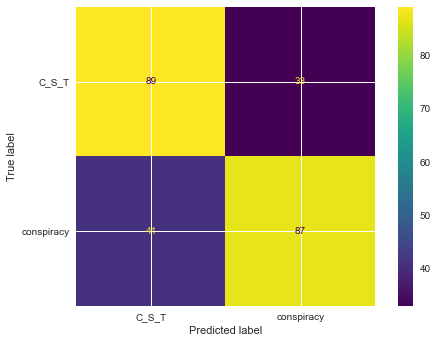

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, cv_pipe.predict(X_test), labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=['C_S_T', 'conspiracy'])

plt.figure(figsize=(25, 25))
disp.plot();
#plt.show();

In [73]:
tn, fp, fn, tp = confusion_matrix(y_test, cv_pipe.predict(X_test), labels=[0, 1]).ravel()
print(tn, fp, fn, tp)

89 33 41 87


In [74]:
word_coefs = cv_pipe.named_steps['logisticregression'].coef_[0]
words = cv_pipe.named_steps['countvectorizer'].get_feature_names_out()
word_coef_df = pd.DataFrame({'Word': words, 'Coef': word_coefs})
word_coef_df.sort_values(by='Coef', ascending=False)

,Word,Coef
20835,proven,0.107768
6704,conspiracy,0.100273
3927,baseless,0.097526
12838,hello,0.093732
20740,proof,0.092658
...,...,...
15644,lawofone,-0.077703
25231,suspect,-0.083357
10183,evaluate,-0.086831
23920,slower,-0.089278


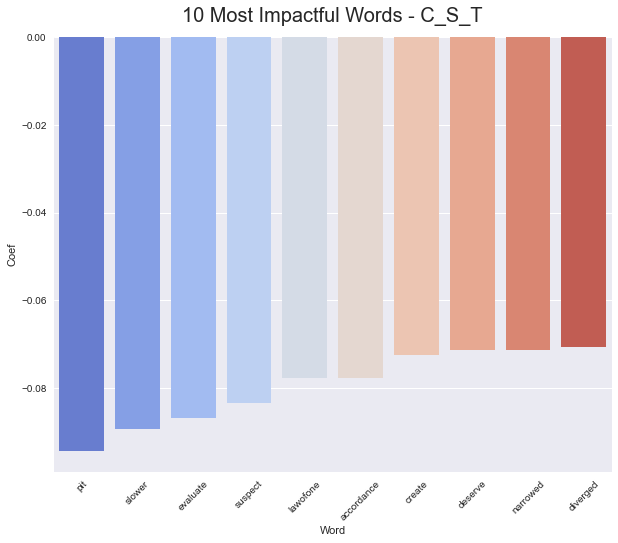

In [78]:
plt.style.use('seaborn')

plt.subplots(figsize=(10, 8))
sns.barplot(data=word_coef_df.sort_values(by='Coef')[:10], x='Word', y='Coef', palette='coolwarm')
plt.xticks(rotation=45)
plt.title('10 Most Impactful Words - C_S_T', fontdict={'fontsize': 20, 'fontweight': 20}, pad=15);

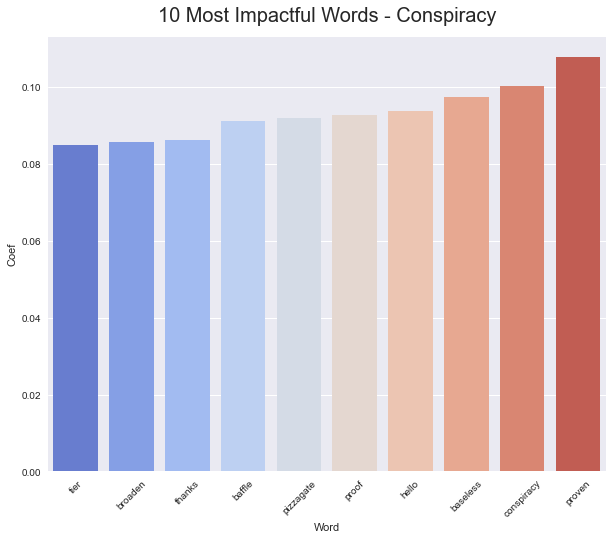

In [88]:
plt.style.use('seaborn')

plt.subplots(figsize=(10, 8))
sns.barplot(data=word_coef_df.sort_values(by='Coef')[-10:], x='Word', y='Coef', palette='coolwarm')
plt.xticks(rotation=45)
plt.title('10 Most Impactful Words - Conspiracy', fontdict={'fontsize': 20, 'fontweight': 20}, pad=15);

### ***Tfidf Vectorizer with Logistic Regression***



In [68]:
# scores w/no train_size 0.92/0.73
tf_pipe = make_pipeline(
    TfidfVectorizer(stop_words='english'),
    #StandardScaler(with_mean=False),
    LogisticRegression(max_iter=5_000, penalty='elasticnet', C=1.0, solver='saga', l1_ratio=0.65)
    #LogisticRegression(max_iter=5_000)
)

tf_pipe.get_params()
# tf_params = {
#     'countvectorizer__binary': [True, False],
#     'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 4), (2, 2)],
#     'countvectorizer__stop_words': [None, 'english'],
#     'countvectorizer__max_features': [None, 100, 200],
#     'countvectorizer__max_df': [0.5, 0.75, 1]
# }


tf_pipe.fit(X_train, y_train)
# gs = GridSearchCV(estimator=tf_pipe, param_grid=tf_params, n_jobs=-1)

# gs.fit(X_train, y_train)

print("Train Score: ", tf_pipe.score(X_train, y_train))
print('Test Score: ', tf_pipe.score(X_test, y_test))

#Best Params:  {'countvectorizer__binary': False, 'countvectorizer__max_df': 0.5, 'countvectorizer__max_features': None, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__stop_words': 'english'}

Train Score:  0.768
Test Score:  0.716


In [81]:
acc = balanced_accuracy_score(y_test, cv_pipe.predict(X_test))
acc

0.7045978483606558

<Figure size 1800x1800 with 0 Axes>

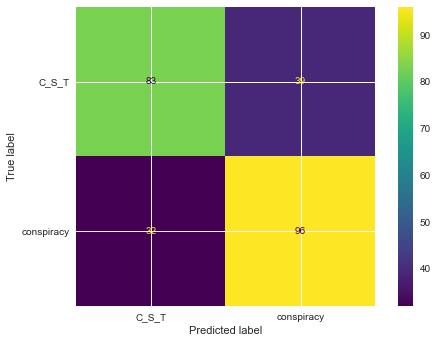

In [86]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, tf_pipe.predict(X_test), labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=['C_S_T', 'conspiracy'])

plt.figure(figsize=(25, 25))
disp.plot();
#plt.show();

***Summary***

TfidfVectorizer ended up outperforming our countvectorizer when used with a LogisticRegression (and without StandardScaler) the score was 0.716. The parameters were optimized and we did manage to sneak over the 0.7 accuracy score that our earlier functions identified when used with defaults (though not by much).

We can see from our confusion matrix that the rate of false positives and false negatives are approximately equal. This model is slightly better at correctly identify posts from r/conspiracy. 

In future iterations of this exercise, I would refine my data cleaning process and do lemmatizing as a preprocessor rather than a data cleaning step. 

Other than that, I'm satisfied with how the models turned out, especially after investigating each subreddit's selftext and understanding just how similar the post content is between these two forums. 